In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utide
import xarray as xr

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


In [3]:
data = "../data/sandy_hook-8531680-usa-noaa"
with open(data) as f:
    lines = f.readlines()

lines[:41]

['# FORMAT VERSION 5.0 Web: https://gesla.org Email: gesla.help@gmail.com\n',
 '# SITE NAME Sandy_Hook\n',
 '# SITE CODE 8531680\n',
 '# COUNTRY USA\n',
 '# CONTRIBUTOR National Oceanic and Atmospheric Administration\n',
 '# CONTRIBUTOR WEBSITE https://api.tidesandcurrents.noaa.gov/api/prod/\n',
 '# CONTRIBUTOR CONTACT co-ops.userservices@noaa.gov\n',
 '# ORGINATOR National Oceanic and Atmospheric Administration\n',
 '# ORIGINATOR WEBSITE https://api.tidesandcurrents.noaa.gov/api/prod/\n',
 '# ORIGINATOR CONTACT co-ops.userservices@noaa.gov\n',
 '# LATITUDE      40.46694400\n',
 '# LONGITUDE    -74.00944400\n',
 '# COORDINATE SYSTEM Unspecified\n',
 '# START DATE/TIME 1910/01/01 01:00:00\n',
 '# END DATE/TIME 2021/08/31 23:00:00\n',
 '# NUMBER OF YEARS 101\n',
 '# TIME ZONE HOURS 0\n',
 '# DATUM INFORMATION Station Datum\n',
 '# INSTRUMENT Unspecified\n',
 '# PRECISION Unspecified\n',
 '# NULL VALUE -99.9999\n',
 '# GAUGE TYPE Coastal\n',
 '# OVERALL RECORD QUALITY No obvious issues\n'

In [4]:
names = ["date", "hour", "sealevel", "flag", "use_flag"]
location= 'Sandy Hook'

#Read data from file
obs = pd.read_csv(
    data,
    names=names,
    skiprows=41, # to skip the large header and documentation, would need to check whether this is the same for every time series
    skipinitialspace=True,
    delim_whitespace=True,
    na_values="-99.9999",
)

#Turn bad data to nan using flags
good_data = obs['use_flag'] == 1
bad_data = obs['use_flag'] == 0
obs.loc[bad_data, "sealevel"] = np.nan

#Subtract mean and define datetime
obs["anomaly"] = obs['sealevel'] - obs['sealevel'].mean()
obs['datetime'] = pd.to_datetime(obs['date'] + ' ' +obs['hour'])

#Checking good and bad data
print("# of bad data =",len (obs.loc[bad_data]),"# of good data =",len (obs.loc[good_data]),"# of data =", len(obs.sealevel))


/vftmp/Olivia.Mcredmond/pid217531/ipykernel_219611/662214102.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  obs = pd.read_csv(


# of bad data = 51214 # of good data = 818890 # of data = 870104


In [5]:
# Define times series for analysis
t1 = (obs['datetime'] >= '1800-1-1') & (obs['datetime'] <= '2021-12-31')
obs_t1=obs.loc[t1]

In [6]:
# Remove tides- will find fourier transform of anomaly series. Find coefficents of frequencies for each tide (defined by constituents) within this series.
coef = utide.solve(
    obs_t1.datetime,
    obs_t1.anomaly,
    lat=  40.46694400,
    method="ols",
    conf_int="MC",
    verbose=False,
   constit=['M2', 'K1', 'O1', 'S2', 'P1', 'N2', 'K2'
# Alternative constituents: 'Q1','NU2', 'L2','J1', 'NO1', 'MK3', 'MO3', 'MU2', 'OO1', 'SO1', 'SSA', '2N2', 'S1','M4', 'TAU1', 'SO3', 'LDA2', 'MF', 'T2', 'RHO1', 'SIG1', 'PI1','MS4', 'PHI1', 'PSI1', 'BET1', 'SK3', 'M6', 'MN4', '2Q1', 'MSN2','H2', 'CHI1', '2MK5', '2MS6', 'EPS2', 'THE1', 'H1', 'MM', 'ALP1','2MN6', 'UPS1', 'ETA2', 'MK4', 'GAM2', '2MK6', 'S4', 'SN4', 'MKS2','MSM', 'OQ2', 'R2', 'MSK6', 'MSF', 'SK4', '2SM6', 'M8', '3MK7','M3', '2SK5'
           ] 
)

# Reconstruct using coefficients defined from utide for a defined time length ('obs_1.datetime' in this case)
tide = utide.reconstruct(obs_t1.datetime, coef, verbose=False)


In [7]:
#Subtract Tide from series
obs_t1['sealevel_tr'] = obs_t1.anomaly - tide.h

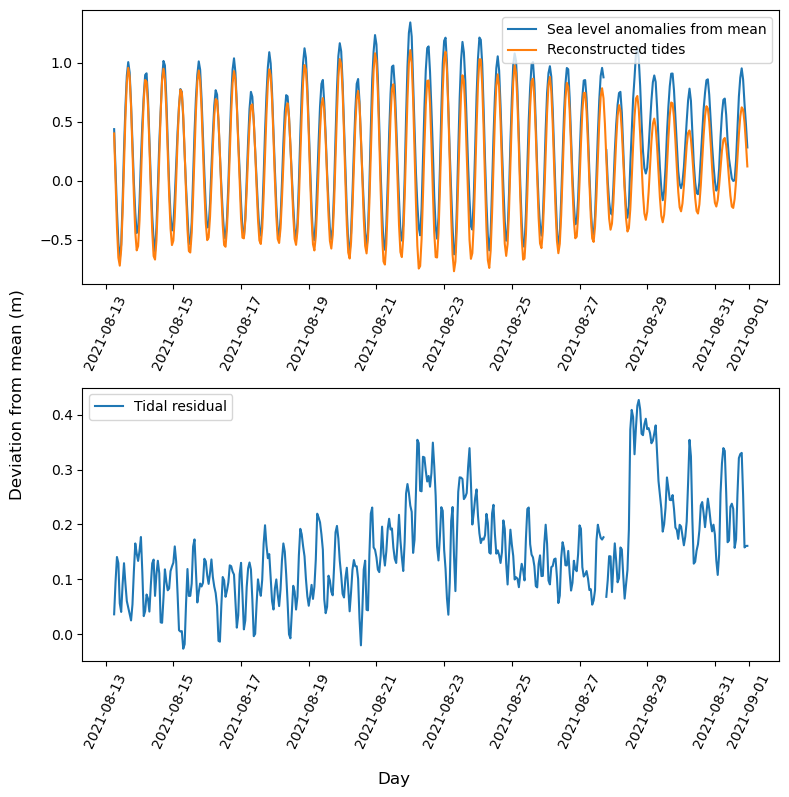

In [8]:
# view orginal measurements, tidal pattern, and sea level trend for short period of time
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8,8))

axs[0].plot(obs_t1.datetime[(-30*15):], obs_t1.anomaly[(-30*15):], label="Sea level anomalies from mean")
axs[0].plot(obs_t1.datetime[(-30*15):], tide.h[(-30*15):], label="Reconstructed tides")
axs[0].legend()
axs[0].tick_params(axis='x', labelrotation=65)

axs[1].plot(obs_t1.datetime[(-30*15):], obs_t1.sealevel_tr[(-30*15):], label="Tidal residual")
axs[1].legend()
axs[1].tick_params(axis='x', labelrotation=65)

fig.supxlabel('Day')
fig.supylabel('Deviation from mean (m)')
plt.tight_layout()

In [9]:
# Double check datetime is in the correct format
obs_t1['datetime'] = pd.to_datetime(obs_t1['datetime'])
# Set the datetime column as the index
obs_t1.set_index('datetime', inplace=True)

In [10]:
# Resample from hourly to daily and calculate the daily average
daily_avg=obs_t1['sealevel_tr'].resample('D').mean()
daily_avg=daily_avg.to_frame()
daily_avg['anomaly']=obs_t1['anomaly'].resample('D').mean()
daily_avg['datetime']=daily_avg.index
daily_avg

,sealevel_tr,anomaly,datetime
datetime,,,
1910-01-01,NaN,NaN,1910-01-01
1910-01-02,NaN,NaN,1910-01-02
1910-01-03,NaN,NaN,1910-01-03
1910-01-04,NaN,NaN,1910-01-04
1910-01-05,NaN,NaN,1910-01-05
...,...,...,...
2021-08-27,0.126640,0.271395,2021-08-27
2021-08-28,0.255912,0.415534,2021-08-28
2021-08-29,0.273008,0.430326,2021-08-29


## Plots- Tidal residual, seasonal pattern, extremes over times series, extreme occurences and associated day of year, histogram distribution

In [22]:
# check quantile works
p999 = daily_avg.sealevel_tr.quantile(1-1e-4) # for hourly datasets a .9999 quantile is approximately once every 10 years
p999

1.1080034167869273

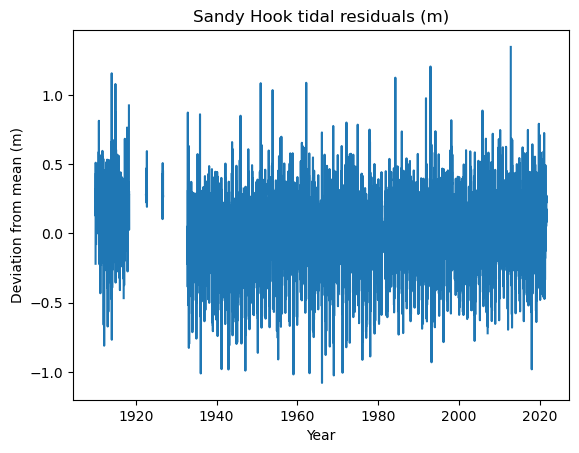

In [23]:
# Plot tidal residual
plt.plot(daily_avg.datetime,daily_avg.sealevel_tr, label="Sea level tidal residual")#obs_t1.datetime, obs_t1.sealevel_tr
plt.title(f"{location} tidal residuals (m)")
#plt.xlim(pd.to_datetime('1976-01-1'), pd.to_datetime('1976-12-31'))
plt.xlabel('Year')
plt.ylabel('Deviation from mean (m)')

plt.savefig(r"C:\Users\deros\Downloads\CIMES project\Sandy_hook 2011-2021\Sandy_hook_residuals.png", format="png")

### Extremes over time series

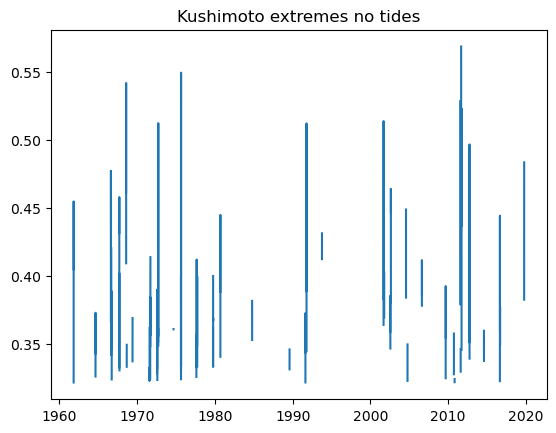

In [27]:
#Plots extreme events over time series
q99 =daily_avg.sealevel_tr.quantile(0.99)
ds_extreme = daily_avg.where(daily_avg.sealevel_tr>= q99)
plt.title(f"{location} extremes no tides")
plt.plot(daily_avg.datetime, ds_extreme.sealevel_tr, label="Sandy_hook Extremes")

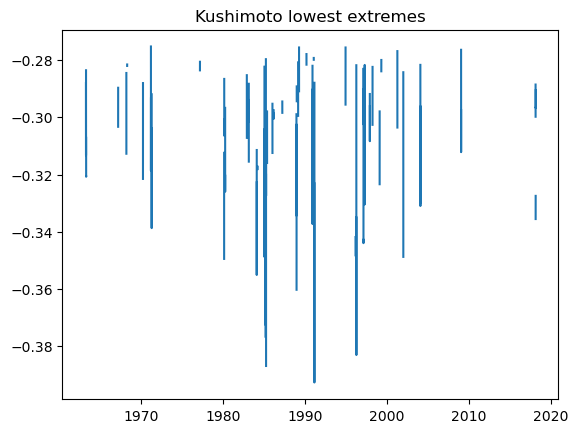

In [28]:
q99 = daily_avg.sealevel_tr.quantile(0.01)

ds_extreme_low = daily_avg.where(daily_avg.sealevel_tr <= q99)
plt.title(f"{location} lowest extremes")

plt.plot(daily_avg.datetime, ds_extreme_low.sealevel_tr, label="Sandy_hook lowest Extremes")

### Seasonal Cycles

Text(0.5, 1.0, 'Kushimoto Seasonal cycle No tides')

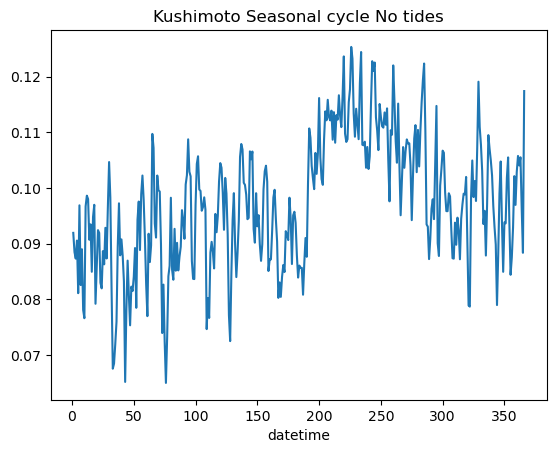

In [16]:
# Plot mean for each day of the year to show seasonal cycle
seasonal_stdev = daily_avg.sealevel_tr.groupby(daily_avg.datetime.dt.dayofyear).std()
(seasonal_stdev).plot(label="Sandy_hook")
plt.title(f"{location} Seasonal cycle No tides")
#plt.savefig(f"C:\\Users\\deros\\Downloads\\{year_start}-{year_end}", format="png")

Text(0.5, 1.0, 'Kushimoto Seasonal cycle No tides')

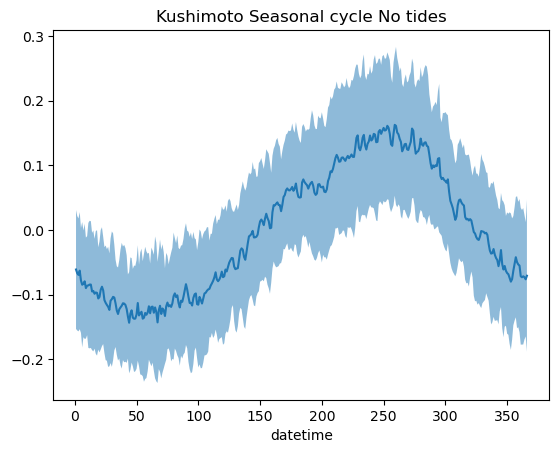

In [17]:
# Plot mean for each day of the year to show seasonal cycle
seasonal_Sandy_hook = daily_avg.sealevel_tr.groupby(daily_avg.datetime.dt.dayofyear).mean()
(seasonal_Sandy_hook).plot(label="Sandy_hook")
plt.fill_between(seasonal_Sandy_hook.index, seasonal_Sandy_hook+seasonal_stdev,seasonal_Sandy_hook-seasonal_stdev, alpha=0.5)
plt.title(f"{location} Seasonal cycle No tides")
#plt.savefig(f"C:\\Users\\deros\\Downloads\\{year_start}-{year_end}", format="png")

Text(0.5, 1.0, 'Kushimoto Extremes seasonal cycle no tides')

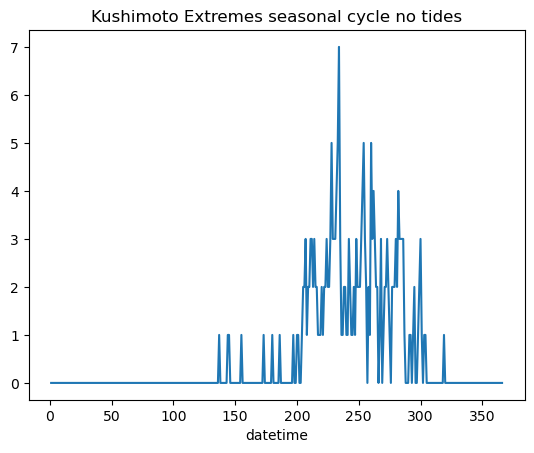

In [31]:
(ds_extreme.sealevel_tr.groupby(daily_avg.datetime.dt.dayofyear).count()).plot()
plt.title(f"{location} Extremes seasonal cycle no tides")

### Histograms

Text(0.5, 1.0, 'Kushimoto Deviation from Mean Sea level No tides')

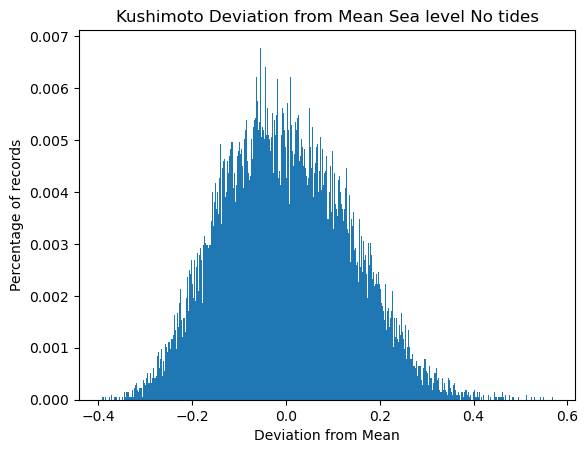

In [32]:
daily_avg.sealevel_tr.plot.hist(bins=500,weights=1/len(daily_avg.sealevel_tr) * np.ones(len(daily_avg.sealevel_tr)))
plt.ylabel("Percentage of records")
plt.xlabel("Deviation from Mean")
plt.title(f"{location} Deviation from Mean Sea level No tides")

datetime
1958-01-01      (-0.145, -0.123]
1958-01-02      (-0.256, -0.234]
1958-01-03      (-0.212, -0.189]
1958-01-04      (-0.189, -0.167]
1958-01-05      (-0.167, -0.145]
                     ...        
2019-12-27      (-0.123, -0.101]
2019-12-28      (-0.167, -0.145]
2019-12-29      (-0.145, -0.123]
2019-12-30    (-0.0788, -0.0567]
2019-12-31      (-0.212, -0.189]
Freq: D, Name: sealevel_tr, Length: 22645, dtype: category
Categories (100, interval[float64, right]): [(-1.21, -1.185] < (-1.185, -1.163] < (-1.163, -1.141] < (-1.141, -1.119] ... (0.917, 0.939] < (0.939, 0.962] < (0.962, 0.984] < (0.984, 1.006]] 

sealevel_tr
(-1.21, -1.185]     0.000044
(-1.185, -1.163]    0.000000
(-1.163, -1.141]    0.000000
(-1.141, -1.119]    0.000000
(-1.119, -1.097]    0.000000
                      ...   
(0.895, 0.917]      0.000000
(0.917, 0.939]      0.000000
(0.939, 0.962]      0.000000
(0.962, 0.984]      0.000000
(0.984, 1.006]      0.000044
Name: sealevel_tr, Length: 100, dtype: float64


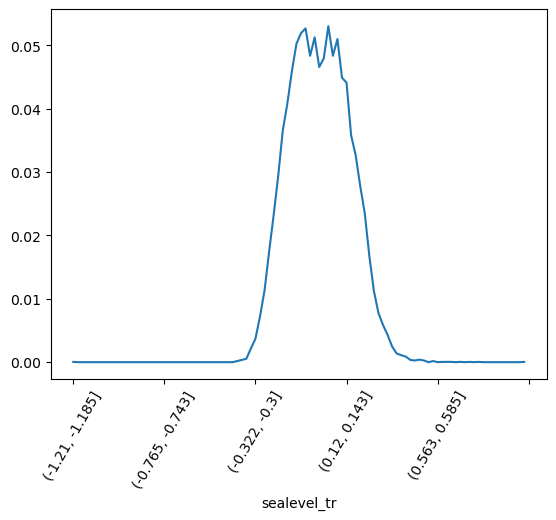

In [60]:
#Alternative Histogram format
bins= pd.cut(daily_avg['sealevel_tr'],bins=100)
print(bins,"\n")
hist=(daily_avg.sealevel_tr.groupby(bins, observed=False).count())/len(daily_avg.sealevel_tr)
print(hist)
hist.plot()
plt.xticks(rotation=60)
print(hist.sum())
print ("skew=",daily_avg.sealevel_tr.skew(),"kurtosis=",daily_avg.sealevel_tr.kurtosis(),"std=", daily_avg.sealevel_tr.std())

In [73]:
print(hist.skew(),hist.kurtosis(),hist.std())

0.8709672167914079 -0.7510496596637806 62.314929003839026


In [74]:
daily_avg.sealevel_tr.skew(),daily_avg.sealevel_tr.kurtosis(),daily_avg.sealevel_tr.std()

(0.2764310337738089, 0.015464990949484392, 0.1010393706951585)

## Save file

In [33]:
# Save to netcdf file
daily_set = xr.Dataset.from_dataframe(daily_avg)
daily_set.to_netcdf('/vftmp/Olivia.Mcredmond/data/cdf files/kushimoto.cdf')